# This notebook examines the excess survival odds for Danish twins and U.S. siblings of centenarians

# Imports

In [10]:
# Project setup and imports
import os, sys, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from svgutils.compose import Figure, Panel, SVG
import pickle
from matplotlib import colors as mcolors
from scipy.signal import savgol_filter
from scipy import stats

# Locate project root and add to path
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'src').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-specific imports
from src.simulation import SR_sim
from src.plotting import SR_plotting
import src.sr_utils as utils
import src.correlation_analysis as ca
import src.twin_analysis as ta
import src.gamma_gompertz as gg
import src.survival_analysis as sa
import src.hetero_plotting as hp
from src.HMD_lifetables import HMD
import saved_results.twin_studies_data as td
import saved_results.model_param_calibrations as pc

# Reproducibility setup
SEED = int(os.environ.get('PYTHONHASHSEED', '12345'))
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
RNG = np.random.default_rng(12345)

# Deterministic sampling helpers
def choice_deterministic(a, size=None, replace=True, p=None):
    return RNG.choice(a, size=size, replace=replace, p=p)

def rand_uniform(size=None):
    return RNG.random(size)

# Matplotlib configuration
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot styling
plt.rc('axes', facecolor='white', grid=False)
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=16)
plt.rc('axes', titlesize=28, labelsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick.major', size=8, width=2.5)
plt.rc('ytick.major', size=8, width=2.5)
plt.rc('xtick.minor', size=5, width=2.5)
plt.rc('ytick.minor', size=5, width=2.5)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=28)

def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Jupyter extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Excess Survival Probability

## Danish

In [2]:
twins_RSP_data = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'twins_RSP.csv'))
twins_RSP_data['MZ male - 1'] = twins_RSP_data['MZ male'] - 1
twins_RSP_data['MZ male lower error'] = twins_RSP_data['MZ male error'].apply(lambda x: float(x.split('-')[0])) - twins_RSP_data['MZ male']
twins_RSP_data['MZ male upper error'] = twins_RSP_data['MZ male error'].apply(lambda x: float(x.split('-')[1])) - twins_RSP_data['MZ male']
twins_RSP_data['DZ male - 1'] = twins_RSP_data['DZ male'] - 1
twins_RSP_data['DZ male lower error'] = twins_RSP_data['DZ male error'].apply(lambda x: float(x.split('-')[0])) - twins_RSP_data['DZ male']
twins_RSP_data['DZ male upper error'] = twins_RSP_data['DZ male error'].apply(lambda x: float(x.split('-')[1])) - twins_RSP_data['DZ male']
twins_RSP_data['MZ female - 1'] = twins_RSP_data['MZ female'] - 1
twins_RSP_data['MZ female lower error'] = twins_RSP_data['MZ female error'].apply(lambda x: float(x.split('-')[0])) - twins_RSP_data['MZ female']
twins_RSP_data['MZ female upper error'] = twins_RSP_data['MZ female error'].apply(lambda x: float(x.split('-')[1])) - twins_RSP_data['MZ female']
twins_RSP_data['DZ female - 1'] = twins_RSP_data['DZ female'] - 1
twins_RSP_data['DZ female lower error'] = twins_RSP_data['DZ female error'].apply(lambda x: float(x.split('-')[0])) - twins_RSP_data['DZ female']
twins_RSP_data['DZ female upper error'] = twins_RSP_data['DZ female error'].apply(lambda x: float(x.split('-')[1])) - twins_RSP_data['DZ female']


In [3]:
model = gg.GammaGompertz()
# Set model parameters using Denmark calibration
model.a = pc.mgg_calibrations['denmark']['a']
model.b = pc.mgg_calibrations['denmark']['b']
model.c = pc.mgg_calibrations['denmark']['c']
model.m = pc.mgg_calibrations['denmark']['m']

mgg_MZ_death_table = model.create_death_table_for_twins(n = int(1e5), std = pc.mgg_calibrations['denmark']['std'], twin_type = 'MZ')
mgg_DZ_death_table = model.create_death_table_for_twins(n = int(1e5), std = pc.mgg_calibrations['denmark']['std'], twin_type = 'DZ')

sr_params = pc.sr_calibrations['denmark'].copy()
sr_dict = pc.country_dicts['denmark'].copy()
n = int(3e5)
# Danish twin cohort fits
sim_dict = utils.create_param_distribution_dict(params='Xc', std=sr_params['Xc_std'], n=n, family='MZ', params_dict=sr_dict)
Xc_sim_MZ = utils.create_sr_simulation(params_dict=sim_dict, n=n, h_ext=sr_params['m_ex'], parallel = True)
print('done MZ')
sim_dict = utils.create_param_distribution_dict(params='Xc', std=sr_params['Xc_std'], n=n, family='DZ', params_dict=sr_dict)
Xc_sim_DZ = utils.create_sr_simulation(params_dict=sim_dict, n=n, h_ext=sr_params['m_ex'], parallel = True)
print('done DZ')



done MZ
done DZ


Exponential decay slopes for excess survival probability:
Twin Type  Sex      Slope       
------------------------------------------------------------
MZ         Male     0.157625    
MZ         Female   0.156853    
DZ         Male     0.133554    
DZ         Female   0.143519    


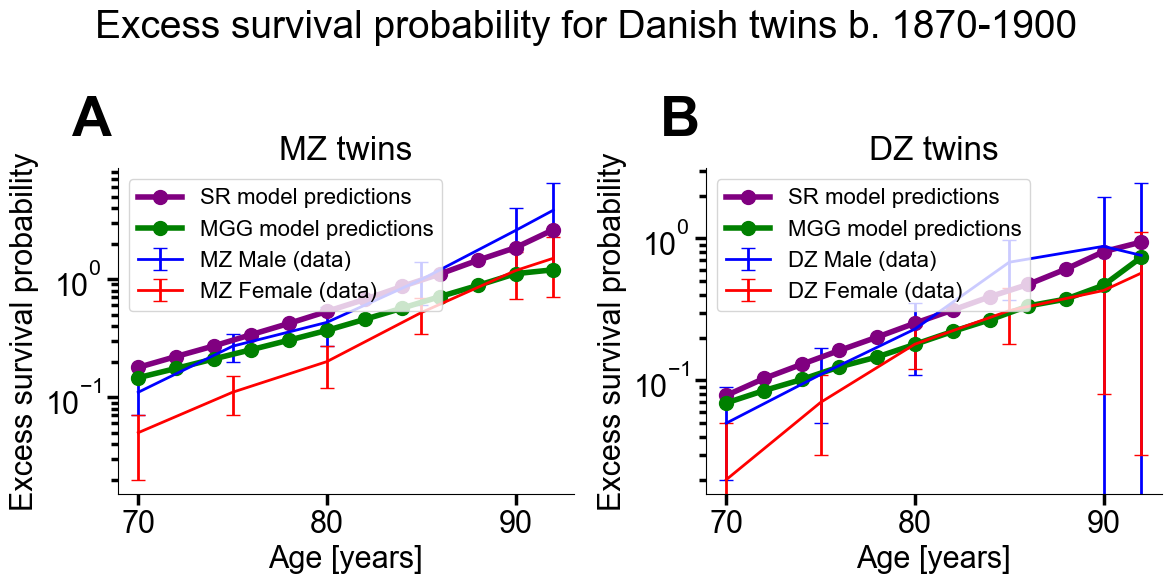

In [11]:
filtered_RSP_data = twins_RSP_data[twins_RSP_data['Age'] >= 70]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Add subplot labels (a) and (b)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, 
         fontsize=40, fontweight='bold', fontname='Arial')

# Function to plot data and fit line for a twin type
def plot_twin_data(ax, data, twin_type, sex_color_map={'male': 'blue', 'female': 'red'}):
    slopes = {}
    for sex in ['male', 'female']:
        # Extract data
        y_data = data[f'{twin_type} {sex} - 1']
        # Fix error bar calculation - use absolute values of the error columns
        yerr = [np.abs(data[f'{twin_type} {sex} lower error']), 
                np.abs(data[f'{twin_type} {sex} upper error'])]
        x_data = data['Age']
        
        # Calculate log-linear fit
        log_y = np.log(y_data)
        slope, intercept, r_value, _, _ = stats.linregress(x_data, log_y)
        slopes[sex] = slope
        fit_line = np.exp(intercept + slope * x_data)
        
        # Plot data points with error bars
        ax.errorbar(x_data, y_data, yerr=yerr, fmt='-', color=sex_color_map[sex], 
                   capsize=5, label=f'{twin_type} {sex.capitalize()} (data)', markersize=5, linewidth=2)
        
        # Plot fit line
        #ax.plot(x_data, fit_line, linestyle='--', color=sex_color_map[sex], 
         #      label=f'{twin_type} {sex.capitalize()} fit: slope={slope:.4f}, R²={r_value**2:.4f}')
    
    return slopes

# Plot MZ twins data and fit
mz_slopes = plot_twin_data(ax1, filtered_RSP_data, 'MZ')
ax1.legend(loc='upper left', fontsize=32, prop={'family': 'Arial'})

# Add Xc simulation data to MZ plot
ages = range(70, 94, 2)
intercept, slope = sa.excess_survival_prob_past_age_X_exponential_fit(Xc_sim_MZ, ages, filter_age=6)
hp.plot_relative_survival_prob_to_age(sim=Xc_sim_MZ, ax=ax1, filter_age=6, ages=ages, color=utils.param_colors['Xc'], marker = 'o', markersize = 10, label = 'SR model predictions', linewidth=4)
hp.plot_relative_survival_prob_to_age(death_table=mgg_MZ_death_table, ax=ax1, filter_age=6, ages=ages, color='green', marker = 'o', markersize = 10, label = 'MGG model predictions', linewidth=4)
ax1.legend(loc='upper left', fontsize=32, prop={'family': 'Arial'})

# Plot DZ twins data and fit
dz_slopes = plot_twin_data(ax2, filtered_RSP_data, 'DZ')
hp.plot_relative_survival_prob_to_age(sim=Xc_sim_DZ, ax=ax2, filter_age=6, ages=ages, color=utils.param_colors['Xc'], marker = 'o', markersize = 10, label = 'SR model predictions', linewidth=4)
hp.plot_relative_survival_prob_to_age(death_table=mgg_DZ_death_table, ax=ax2, filter_age=6, ages=ages, color='green', marker = 'o', markersize = 10, label = 'MGG model predictions', linewidth=4)
ax2.legend(loc='upper left', fontsize=32, prop={'family': 'Arial'})

# Print slopes nicely formatted
print("Exponential decay slopes for excess survival probability:")
print("=" * 60)
print(f"{'Twin Type':<10} {'Sex':<8} {'Slope':<12}")
print("-" * 60)
print(f"{'MZ':<10} {'Male':<8} {mz_slopes['male']:<12.6f}")
print(f"{'MZ':<10} {'Female':<8} {mz_slopes['female']:<12.6f}")
print(f"{'DZ':<10} {'Male':<8} {dz_slopes['male']:<12.6f}")
print(f"{'DZ':<10} {'Female':<8} {dz_slopes['female']:<12.6f}")
print("=" * 60)

# Configure axes
for ax, title in zip([ax1, ax2], ['MZ Twins', 'DZ Twins']):
    ax.set_yscale('log')
    ax.set_xlabel('Age [years]', fontsize=22, fontname='Arial')
    ax.set_ylabel('Excess survival probability', fontsize=22, fontname='Arial')
    ax.tick_params(axis='both', which='major', labelsize=22)
    
ax1.set_title('MZ twins', fontsize=24, fontname='Arial')
ax2.set_title('DZ twins', fontsize=24, fontname='Arial')

fig.suptitle('Excess survival probability for Danish twins b. 1870-1900', 
             fontsize=28, fontname='Arial', y=0.98)
plt.tight_layout()
saved_fig = fig
plt.show()


## American cohort

### loading mortality data

In [12]:
# load usa mortality data for year 1900
def load_usa_cohort_death_rates(year, gender='both',
                                path=PROJECT_ROOT / "saved_data" / "usa_cohort_death_rates.txt"):
    """
    Load USA cohort death rates for a specific year and gender.
    
    Parameters:
    -----------
    year : int
        The birth cohort year to load
    gender : str, default 'both'
        One of 'male', 'female', or 'both'
    path : str
        Path to the data file
        
    Returns:
    --------
    hazard_tspan : numpy array
        Ages (years)
    hazard : numpy array
        Death rates at each age
    """
    
    # Skip the first two lines (header and blank line), use line 3 as column names
    df = pd.read_csv(path, sep=r"\s+", engine="python", na_values=".", skiprows=2)
    
    # Select hazard column based on gender
    gender = gender.lower()
    if gender == 'female':
        hazard_col = 'Female'
    elif gender == 'male':
        hazard_col = 'Male'
    elif gender == 'both':
        hazard_col = 'Total'
    else:
        raise ValueError("gender must be one of: 'male', 'female', 'both'")

    # Filter for the specified year
    df_year = df[df['Year'] == year].copy()
    if df_year.empty:
        raise ValueError(f"No data found for year {year}")

    # Convert Age to numeric; handle '110+' by converting to 110
    df_year['Age'] = df_year['Age'].astype(str).str.replace('+', '', regex=False)
    df_year['Age'] = pd.to_numeric(df_year['Age'], errors='coerce')

    # Keep only rows with valid age and hazard data
    df_clean = df_year[['Age', hazard_col]].dropna().sort_values(by='Age')

    hazard_tspan = df_clean['Age'].to_numpy(dtype=float)
    hazard = df_clean[hazard_col].to_numpy(dtype=float)

    return hazard_tspan, hazard

### SR model

In [ ]:
# Use the pre-calibrated USA parameters from model_param_calibrations.py
sr_dict = pc.sr_usa_dict.copy()
n = int(5e5)
std = pc.sr_calibrations['usa']['Xc_std']
sr_dict
sim_dict = utils.create_param_distribution_dict(params='Xc', std=std, n=n, family='DZ', params_dict=sr_dict)
Xc_sim = utils.create_sr_simulation(params_dict=sim_dict, n=n, parallel=True, h_ext = sr_dict['m_ex'])
Xc_sim_plotter = SR_plotting(Xc_sim)

(18.0, 110.0)

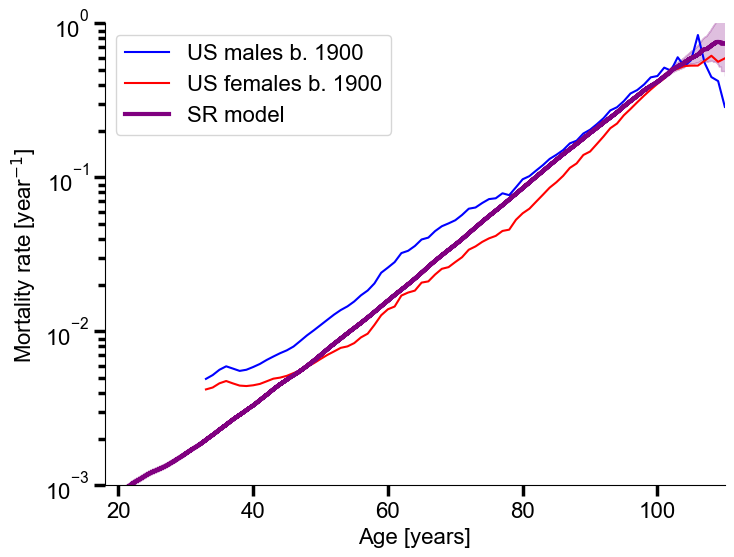

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ages, hz_m = load_usa_cohort_death_rates(1900, gender='male')
ax.plot(ages, hz_m, label='US males b. 1900', color = 'blue')
ages, hz_f = load_usa_cohort_death_rates(1900, gender='female')
ax.plot(ages, hz_f, label='US females b. 1900', color = 'red')
ax.legend(fontsize=12, prop={'family': 'Arial'})
ax.tick_params(axis='both', which='major', labelsize=16)
Xc_sim_plotter.plot_hazard(ax=ax, color = 'purple', label = 'SR model', linewidth = 3)
ax.grid(False)
ax.set_yscale('log')
ax.set_ylim(1e-3,1)
ax.set_xlabel('Age [years]', fontsize=16, fontname='Arial')
ax.set_ylabel(r'Mortality rate [year$^{-1}$]', fontsize=16, fontname='Arial')
ax.set_xlim(18, 110)


### MGG model

Fitted to custom hazard arrays:
a:  0.00011410095921164198
b:  0.08699117826991204
c:  8.99244157541045
m:  0.0026256433227093354
a:  9.12807673693136e-05
b:  0.08699117826991204
c:  100
m:  0.001


(18.0, 110.0)

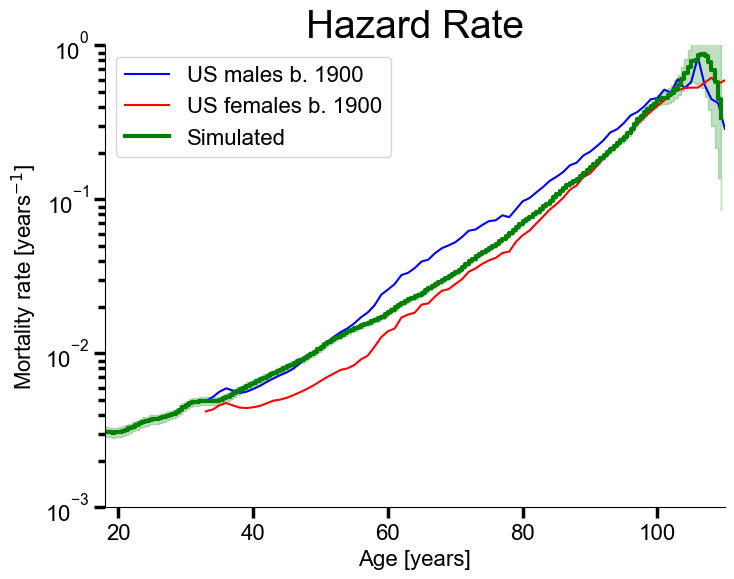

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ages, hz_m = load_usa_cohort_death_rates(1900, gender='male')
ax.plot(ages, hz_m, label='US males b. 1900', color = 'blue')
ages, hz_f = load_usa_cohort_death_rates(1900, gender='female')
ax.plot(ages, hz_f, label='US females b. 1900', color = 'red')

mgg_usa = gg.GammaGompertz()
mgg_usa_params = pc.mgg_calibrations['usa']
mgg_usa.a = mgg_usa_params['a']
mgg_usa.b = mgg_usa_params['b']
mgg_usa.c = mgg_usa_params['c']
mgg_usa.m = mgg_usa_params['m']
std = mgg_usa_params['std']


mgg_usa.print_params()

death_times, _ = mgg_usa.sample_death_times_with_random_param(n=50000, param_name='b', dt=0.5, std=std, coupled_ab=True)

# Left subplot: Plot hazard comparison
mgg_usa.plot_hazard_from_death_times(death_times, ax=ax, label='Simulated', color = 'green', linewidth = 3)
ax.set_title('Hazard Rate')


ax.legend(fontsize=12, prop={'family': 'Arial'})
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(False)
ax.set_yscale('log')
ax.set_ylim(1e-3,1)
ax.set_xlabel('Age [years]', fontsize=16, fontname='Arial')
ax.set_ylabel(r'Mortality rate [years$^{-1}$]', fontsize=16, fontname='Arial')
ax.set_xlim(18, 110)


### loading relative survival data

In [16]:
# Load the CSV data
df = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'US_sibs_centenarians_RSP.csv'))

# Define ESP (Excess Survival Probability) columns - RSP minus 1
df['esp_male'] = df['Male_RSP'] - 1
df['esp_female'] = df['Female_RSP'] - 1

# Define ESP error bounds - also subtract 1 from the CI bounds
df['esp_male_lower'] = df['Male_Lower_CI'] - 1
df['esp_male_upper'] = df['Male_Upper_CI'] - 1
df['esp_female_lower'] = df['Female_Lower_CI'] - 1
df['esp_female_upper'] = df['Female_Upper_CI'] - 1

# Calculate error bar arrays (distance from central value to bounds)
male_yerr = [df['esp_male'] - df['esp_male_lower'], 
             df['esp_male_upper'] - df['esp_male']]
female_yerr = [df['esp_female'] - df['esp_female_lower'], 
               df['esp_female_upper'] - df['esp_female']]


# The Figure

Exponential decay slopes for excess survival probability:
Twin Type  Sex      Slope       
------------------------------------------------------------
MZ         Male     0.157625    
MZ         Female   0.156853    
DZ         Male     0.133554    
DZ         Female   0.143519    


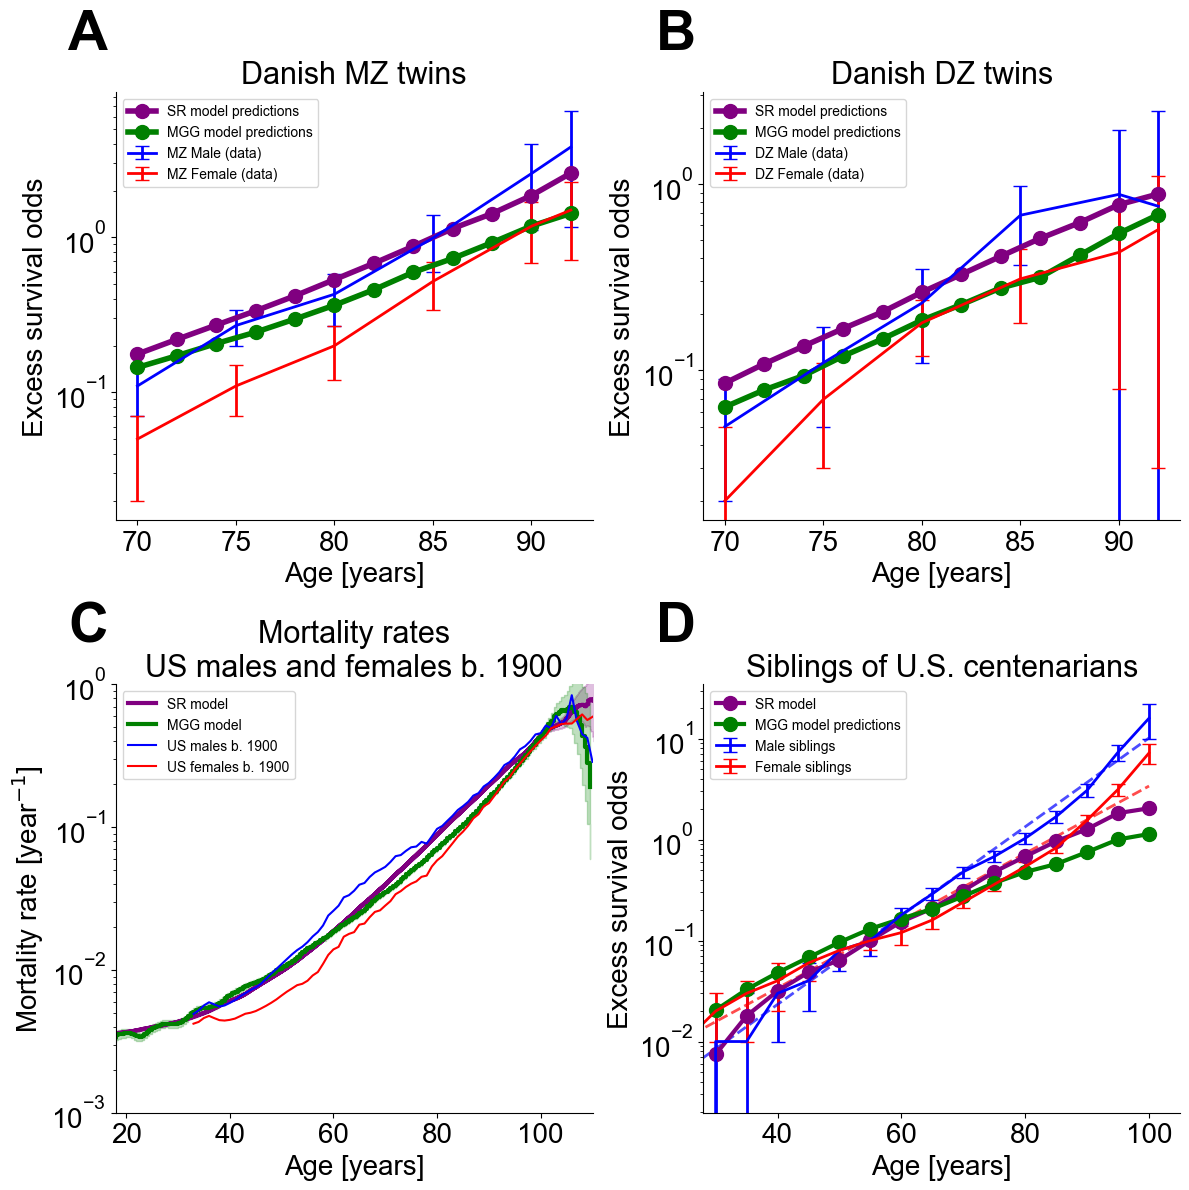

In [ ]:
# Create the plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Define font sizes
axlabel_fontsize = 20
title_fontsize = 22
legend_fontsize = 20
tick_fontsize = 20
subplot_label_fontsize = 40

filtered_RSP_data = twins_RSP_data[twins_RSP_data['Age'] >= 70]

# Add subplot labels (A), (B), (C), (D)
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, 
         fontsize=subplot_label_fontsize, fontweight='bold', fontname='Arial')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, 
         fontsize=subplot_label_fontsize, fontweight='bold', fontname='Arial')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, 
         fontsize=subplot_label_fontsize, fontweight='bold', fontname='Arial')
ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, 
         fontsize=subplot_label_fontsize, fontweight='bold', fontname='Arial')

# Function to plot data and fit line for a twin type
def plot_twin_data(ax, data, twin_type, sex_color_map={'male': 'blue', 'female': 'red'}):
    slopes = {}
    for sex in ['male', 'female']:
        # Extract data
        y_data = data[f'{twin_type} {sex} - 1']
        # Fix error bar calculation - use absolute values of the error columns
        yerr = [np.abs(data[f'{twin_type} {sex} lower error']), 
                np.abs(data[f'{twin_type} {sex} upper error'])]
        x_data = data['Age']
        
        # Calculate log-linear fit
        log_y = np.log(y_data)
        slope, intercept, r_value, _, _ = stats.linregress(x_data, log_y)
        slopes[sex] = slope
        fit_line = np.exp(intercept + slope * x_data)
        
        # Plot data points with error bars
        ax.errorbar(x_data, y_data, yerr=yerr, fmt='-', color=sex_color_map[sex], 
                   capsize=5, label=f'{twin_type} {sex.capitalize()} (data)', markersize=5, linewidth=2)
        
        # Plot fit line
        #ax.plot(x_data, fit_line, linestyle='--', color=sex_color_map[sex], 
         #      label=f'{twin_type} {sex.capitalize()} fit: slope={slope:.4f}, R²={r_value**2:.4f}')
    
    return slopes

# Plot MZ twins data and fit (top left)
mz_slopes = plot_twin_data(ax1, filtered_RSP_data, 'MZ')
ax1.legend(loc='upper left', fontsize=legend_fontsize, prop={'family': 'Arial'})

# Add Xc simulation data to MZ plot
ages = range(70, 94, 2)
intercept, slope = sa.excess_survival_prob_past_age_X_exponential_fit(Xc_sim_MZ, ages, filter_age=6)
hp.plot_relative_survival_prob_to_age(sim=Xc_sim_MZ, ax=ax1, filter_age=6, ages=ages, color=utils.param_colors['Xc'], marker = 'o', markersize = 10, label = 'SR model predictions', linewidth=4)
hp.plot_relative_survival_prob_to_age(death_table=mgg_MZ_death_table, ax=ax1, filter_age=6, ages=ages, color='green', marker = 'o', markersize = 10, label = 'MGG model predictions', linewidth=4)
ax1.legend(loc='upper left', fontsize=legend_fontsize, prop={'family': 'Arial'})

# Plot DZ twins data and fit (top right)
dz_slopes = plot_twin_data(ax2, filtered_RSP_data, 'DZ')
hp.plot_relative_survival_prob_to_age(sim=Xc_sim_DZ, ax=ax2, filter_age=6, ages=ages, color=utils.param_colors['Xc'], marker = 'o', markersize = 10, label = 'SR model predictions', linewidth=4)
hp.plot_relative_survival_prob_to_age(death_table=mgg_DZ_death_table, ax=ax2, filter_age=6, ages=ages, color='green', marker = 'o', markersize = 10, label = 'MGG model predictions', linewidth=4)
ax2.legend(loc='upper left', fontsize=legend_fontsize, prop={'family': 'Arial'})

# Print slopes nicely formatted
print("Exponential decay slopes for excess survival probability:")
print("=" * 60)
print(f"{'Twin Type':<10} {'Sex':<8} {'Slope':<12}")
print("-" * 60)
print(f"{'MZ':<10} {'Male':<8} {mz_slopes['male']:<12.6f}")
print(f"{'MZ':<10} {'Female':<8} {mz_slopes['female']:<12.6f}")
print(f"{'DZ':<10} {'Male':<8} {dz_slopes['male']:<12.6f}")
print(f"{'DZ':<10} {'Female':<8} {dz_slopes['female']:<12.6f}")
print("=" * 60)

# Configure top row axes
for ax, title in zip([ax1, ax2], ['Danish MZ twins', 'Danish DZ twins']):
    ax.set_yscale('log')
    ax.set_xlabel('Age [years]', fontsize=axlabel_fontsize, fontname='Arial')
    ax.set_ylabel('Excess survival odds', fontsize=axlabel_fontsize, fontname='Arial')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.set_title(title, fontsize=title_fontsize, fontname='Arial')

# Bottom left plot (C): Mortality rates
Xc_sim_plotter.plot_hazard(ax=ax3, color = 'purple', label = 'SR model', linewidth = 3)
mgg_usa.plot_hazard_from_death_times(death_times, ax=ax3, label='MGG model', color = 'green', linewidth = 3)
ages, hz_m = load_usa_cohort_death_rates(1900, gender='male')
ax3.plot(ages, hz_m, label='US males b. 1900', color = 'blue')
ages, hz_f = load_usa_cohort_death_rates(1900, gender='female')
ax3.plot(ages, hz_f, label='US females b. 1900', color = 'red')
ax3.grid(False)
ax3.set_yscale('log')
ax3.set_ylim(1e-3,1)
ax3.set_xlabel('Age [years]', fontsize=axlabel_fontsize, fontname='Arial')
ax3.set_title('Mortality rates\nUS males and females b. 1900', fontsize=title_fontsize, fontname='Arial')
ax3.set_ylabel(r'Mortality rate [year$^{-1}$]', fontsize=axlabel_fontsize, fontname='Arial')
ax3.set_xlim(18, 110)
ax3.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax3.legend(fontsize=legend_fontsize, prop={'family': 'Arial'})

# Bottom right plot (D): Excess survival probability
# Plot males in blue with error bars
ax4.errorbar(df['Age'], df['esp_male'], yerr=male_yerr, 
             fmt='o-', color='blue', capsize=5, 
             label='Male siblings', markersize=0, linewidth=2)

# Plot females in red with error bars
ax4.errorbar(df['Age'], df['esp_female'], yerr=female_yerr, 
             fmt='o-', color='red', capsize=5, 
             label='Female siblings', markersize=0, linewidth=2)

# Fit lines to log10 of ESP data
# Filter out zero or negative values for log transformation
male_mask = df['esp_male'] > 0
female_mask = df['esp_female'] > 0

# Fit for males
if male_mask.sum() > 1:
    male_coeffs = np.polyfit(df['Age'][male_mask], np.log10(df['esp_male'][male_mask]), 1)
    male_slope, male_intercept = male_coeffs
    male_fit_line = 10**(male_slope * df['Age'] + male_intercept)
    ax4.plot(df['Age'], male_fit_line, '--', color='blue', alpha=0.7, linewidth=2,
             label=None)

# Fit for females
if female_mask.sum() > 1:
    female_coeffs = np.polyfit(df['Age'][female_mask], np.log10(df['esp_female'][female_mask]), 1)
    female_slope, female_intercept = female_coeffs
    female_fit_line = 10**(female_slope * df['Age'] + female_intercept)
    ax4.plot(df['Age'], female_fit_line, '--', color='red', alpha=0.7, linewidth=2,
             label=None)

hp.plot_relative_survival_prob_to_age_conditional_on_age_Y(sim=Xc_sim,ax=ax4,ages_X = range(30, 101, 5), 
                                                           age_Y = 100, filter_age = 20, label = 'SR model', linewidth = 3, color = 'purple', marker = 'o', markersize = 10)

hp.plot_relative_survival_prob_to_age_conditional_on_age_Y(death_table = mgg_sib_US_death_table,ax=ax4,ages_X = range(30, 101, 5), 
                                                           age_Y = 100, filter_age = 20, label = 'MGG model predictions', linewidth = 3, color = 'green', marker = 'o', markersize = 10)

# Configure the bottom right plot
ax4.set_yscale('log')
ax4.set_xlabel('Age [years]', fontsize=axlabel_fontsize, fontname='Arial')
ax4.set_ylabel('Excess survival odds', fontsize=axlabel_fontsize, fontname='Arial')
ax4.set_title('Siblings of U.S. centenarians', fontsize=title_fontsize, fontname='Arial')
ax4.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax4.set_xlim(28, 105)
ax4.legend(fontsize=legend_fontsize, prop={'family': 'Arial'})

# Set font for tick labels to Arial for all plots
for ax in [ax1, ax2, ax3, ax4]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')

plt.tight_layout()
saved_fig = fig
plt.show()
